# Домашнее задание №3. Дедлайн - 21 ноября
Основы машинного обучения. К.Шематоров  
Группа ML-13. __Студент - Усцов Артем Алексеевич__

## Part 0. Service function declaration

Connecting all the libraries necessary for work and declaring functions

In [1]:
# Main libraries
import numpy as np
import pandas as pd

# import keras as ks
import keras as ks
import nltk
import re
import codecs


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from keras.preprocessing.text import Tokenizer

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Train dataset
train_df = pd.read_csv("/content/drive/MyDrive/ML_Techno_2021/data/train.csv")
train_df.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


In [4]:
# Check the empty data
train_df.isnull().any()

id        False
url       False
title     False
target    False
dtype: bool

In [5]:
# Test dataset
test_df = pd.read_csv("/content/drive/MyDrive/ML_Techno_2021/data/test.csv")
test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [6]:
# Check the empty data
test_df.isnull().any()

id       False
url      False
title    False
dtype: bool

Как видно, пропусков в данных не имеется. Дополнительная обработка данного случая не требуется

In [7]:
print(f"Длина вектора данных на обучении - {len(train_df)}")
print(f"Длина вектора данных на тесте - {len(test_df)}")
print(f"Соотношение теста к обучающим - {round(len(test_df) / len(train_df), 2)}")

Длина вектора данных на обучении - 135309
Длина вектора данных на тесте - 165378
Соотношение теста к обучающим - 1.22


Имеем перекос в размере данных на обучающей выборке на 22%

In [8]:
# Labels balance
train_df["target"].value_counts()

False    118594
True      16715
Name: target, dtype: int64

In [9]:
X_train = train_df["title"].values
X_test = test_df["title"].values
y_train = train_df["target"].astype(int).values

## Part 1. Simple baseline realisation

In [10]:
y_pred = [int("порно" in text) for text in X_train]

In [11]:
print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.897     1.000     0.946    118594
           1      0.989     0.186     0.312     16715

    accuracy                          0.899    135309
   macro avg      0.943     0.593     0.629    135309
weighted avg      0.908     0.899     0.867    135309



AUC-ROC metric: 0.593


Text(0.5, 1.0, 'ROC curve')

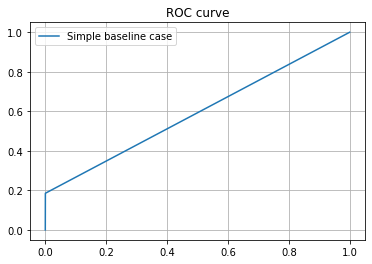

In [12]:
print(f"AUC-ROC metric: {round(roc_auc_score(y_train, y_pred), 3)}")
fpr, tpr, _ = roc_curve(y_train, y_pred)

plt.plot(fpr, tpr, label="Simple baseline case")
plt.legend()
plt.grid()
plt.title('ROC curve')

### Submit

In [13]:
test_df["target"] = [("порно" in text) for text in X_test]

# Create file and read in stdout
test_df[["id", "target"]].to_csv("simple_baseline.csv", index=False)
!cat simple_baseline.csv | head

id,target
135309,False
135310,False
135311,False
135312,False
135313,False
135314,False
135315,False
135316,False
135317,False


### Не все так однозначно

**не порно**:
- Болезни опорно-двигательной системы и импотенция: взаимосвязь
- Транссексуальные рыбы - National Geographic Россия: красота мира в каждом кадре
- Групповая обзорная экскурсия по Афинам - цена €50
- Больного раком Задорнова затравили в соцсетях.
- Гомосексуалисты на «Первом канале»? Эрнст и Галкин – скрытая гей-пара российского шоу-бизнеса | Заметки о стиле, моде и жизни

**порно**:
- Отборная домашка
- Сюзанна - карьера горничной / Susanna cameriera perversa (с русским переводом) 1995 г., DVDRip

## Conclusion:

Требуется добавить отслеживание "схожести" слов, а также важен порядок следования слов в предложении

## Part 1. ML baseline realisation
Использование базовой векторизации и простейшей модели классификации - мультиномиального наивного байесовского классификатора

In [14]:
vectorizer = CountVectorizer()
model = MultinomialNB()

In [15]:
X_train_vectorized = vectorizer.fit_transform(X_train)

In [16]:
feature_names = np.array(vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
id_ = 42
print(X_train[id_])
x_vector = X_train_vectorized.getrow(id_).toarray()[0]
[feature for feature in feature_names[x_vector > 0]]

Презентация на тему "Приближенное значение. Абсолютная и относительная погрешнос


['абсолютная',
 'значение',
 'на',
 'относительная',
 'погрешнос',
 'презентация',
 'приближенное',
 'тему']

In [18]:
%%time

model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_train_vectorized)

CPU times: user 64 ms, sys: 2.03 ms, total: 66 ms
Wall time: 67.5 ms


In [19]:
print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.995     0.976     0.985    118594
           1      0.851     0.963     0.904     16715

    accuracy                          0.975    135309
   macro avg      0.923     0.970     0.945    135309
weighted avg      0.977     0.975     0.975    135309



AUC-ROC metric: 0.97


Text(0.5, 1.0, 'ROC curve')

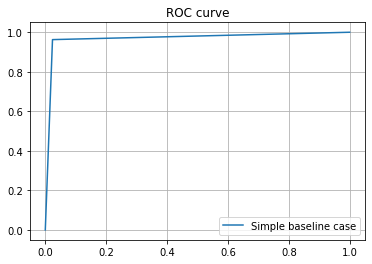

In [20]:
print(f"AUC-ROC metric: {round(roc_auc_score(y_train, y_pred), 3)}")
fpr, tpr, _ = roc_curve(y_train, y_pred)

plt.plot(fpr, tpr, label="Simple baseline case")
plt.legend()
plt.grid()
plt.title('ROC curve')

### Submit

In [21]:
X_test_vectorized = vectorizer.transform(X_test)
test_df["target"] = model.predict(X_test_vectorized).astype(bool)

# Create file and read in stdout
test_df[["id", "target"]].to_csv("ml_baseline.csv", index=False)
!cat ml_baseline.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False


## Conclusion:

Как видно, токенизация слов и простейший классификатор хоть и дают результаты лучше, чем при простом отсеивании по ключевому слову, однако качество все равно оставляет желать лучшего. Попробуем увеличить качество

## Part 2. Smart data processing

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135309 entries, 0 to 135308
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      135309 non-null  int64 
 1   url     135309 non-null  object
 2   title   135309 non-null  object
 3   target  135309 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 3.2+ MB


In [23]:
# Имеется большой перекос в сторону классификации текста как не порносодержащего
train_df.groupby("target").count()

,id,url,title
target,,,
False,118594,118594,118594
True,16715,16715,16715


### Sanitizing input
Let's make sure our tweets only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

In [ ]:
input_file = codecs.open("/content/drive/MyDrive/ML_Techno_2021/data/train.csv", "r", encoding='utf-8', errors='replace')
output_file = open("/content/drive/MyDrive/ML_Techno_2021/data/train.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)

sanitize_characters(input_file, output_file)

In [ ]:
# Train dataset
train_df = pd.read_csv("/content/drive/MyDrive/ML_Techno_2021/data/train.csv/train_clean.csv")
train_df.head(10)

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False
5,5,beregifiguru.ru,Салат: корейская морковь + копченая курица + к...,False
6,6,ekb.vseinstrumenti.ru,"Угловой пневмогайковерт FUBAG RWC 105 1/2"" 100...",False
7,7,mirtabaka.org,Табачный магазин `Мир Табака` | КУРИТЕЛЬНЫЕ ТР...,False
8,8,xlecx.com,league of legends » Page 5 » Porn comics free ...,True
9,9,bus.biletyplus.ua,"08:00 (4766р), Одесса - Ростов-на-Дону 20 сент...",False


Уберем лишние символы в строчках - все возможные запятые, служебные символы и так далее. Также произведем приведение слов к нормальной форме и к нижнему регистру

In [ ]:
import pymorphy2
import re

ma = pymorphy2.MorphAnalyzer()

def clean_text(text, encoding=False):
    text = text.replace("\\", " ").replace(u"╚", " ").replace(u"╩", " ")
    text = text.lower()
    text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #deleting newlines and line-breaks
    text = re.sub('[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols  
    text = " ".join(ma.parse(word)[0].normal_form for word in text.split())
    text = ' '.join(word for word in text.split() if len(word)>3)
    if encoding:
        text = text.encode("utf-8")

    return text

In [ ]:
# It's too long. DO NOT RUN

# train_df['title_clean'] = train_df.apply(lambda x: clean_text(x[u'title']), axis=1)
# train_df['title_clean'] = train_df['title_clean'].astype("str")
# test_df['title_clean'] = test_df.apply(lambda x: clean_text(x[u'title']), axis=1)
# test_df['title_clean'] = test_df['title_clean'].astype("str")

In [ ]:
# train_df.to_csv("clean_train_df.csv")
# test_df.to_csv("clean_test_df.csv")

In [ ]:
# It's too long. DO NOT RUN

# train_df['title_clean'] = train_df.apply(lambda x: clean_text(x[u'title'], True), axis=1)
# train_df['title_clean'] = train_df['title_clean'].astype("str")
# test_df['title_clean'] = test_df.apply(lambda x: clean_text(x[u'title'], True), axis=1)
# test_df['title_clean'] = test_df['title_clean'].astype("str")

In [ ]:
# # Будем использовать уже готовые датасеты, так как онлайн обработка производится существенное время
clean_train_df = pd.read_csv("/content/drive/MyDrive/ML_Techno_2021/data/train.csv/clean_train_df.csv")
clean_train_df['title_clean'] = clean_train_df['title_clean'].astype("str")
clean_test_df = pd.read_csv("/content/drive/MyDrive/ML_Techno_2021/data/train.csv/clean_test_df.csv")
clean_test_df['title_clean'] = clean_test_df['title_clean'].astype("str")

In [ ]:
clean_train_df.head(50)

,Unnamed: 0,id,url,title,target,title_clean
0,0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False,министр экономика молдова глава мидэя цель кот...
1,1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False,этот песня стать известный многий телезритель ...
2,2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False,банша сезон серия бремя красота смотреть онлайн
3,3,3,colorbox.spb.ru,Не Беси Меня Картинки,False,бесить картинка
4,4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False,новомосковск сыграть следж хоккеист алексински...
5,5,5,beregifiguru.ru,Салат: корейская морковь + копченая курица + к...,False,салат корейский морковь копчёный курица кукуру...
6,6,6,ekb.vseinstrumenti.ru,"Угловой пневмогайковерт FUBAG RWC 105 1/2"" 100...",False,угловой пневмогайковерт fubag екатеринбург куп...
7,7,7,mirtabaka.org,Табачный магазин `Мир Табака` | КУРИТЕЛЬНЫЕ ТР...,False,табачный магазин `миро табака` курительный тру...
8,8,8,xlecx.com,league of legends » Page 5 » Porn comics free ...,True,league legends page porn comics free online
9,9,9,bus.biletyplus.ua,"08:00 (4766р), Одесса - Ростов-на-Дону 20 сент...",False,одесса ростов сентябрь фаворит


In [ ]:
# Как можно видеть, после нормализации и очистки, мы имеем строчки со значением nan - уберем их из датасета
clean_train_df = clean_train_df[clean_train_df['title_clean'] != 'nan']

In [ ]:
# На первом этапе произведем токенизацию слов
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
clean_train_df["tokens"] = clean_train_df["title_clean"].apply(tokenizer.tokenize)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in clean_train_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_train_df["tokens"]]

VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

945970 words total, with a vocabulary size of 117701
Max sentence length is 50


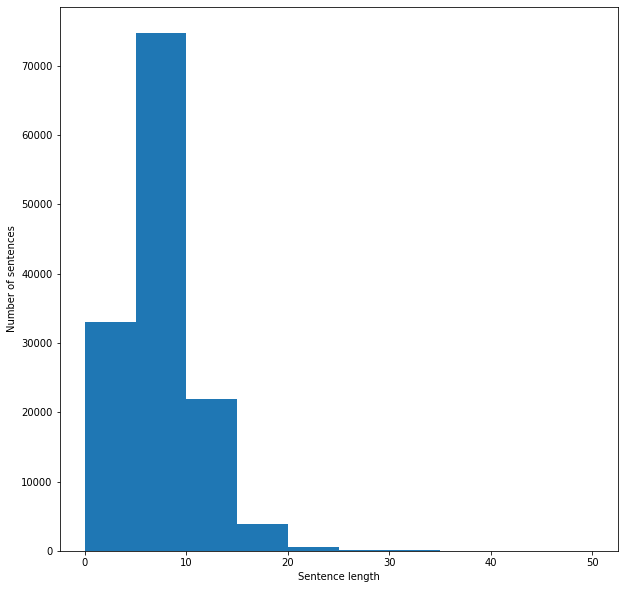

In [ ]:
# Посмотрим на распределение длин слов
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## Part 2.1 Tokenizing
Используем токенизацию слов на чистом датасете

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = clean_train_df["title_clean"].tolist()
list_labels = clean_train_df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.30, 
                                                                              random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Попробуем спроецировать все наше n-мерное пространство признаков в 2-х мерное пространство при помощи метода главных компонент, чтобы проверить, насколько хорошо разделимы наши данные

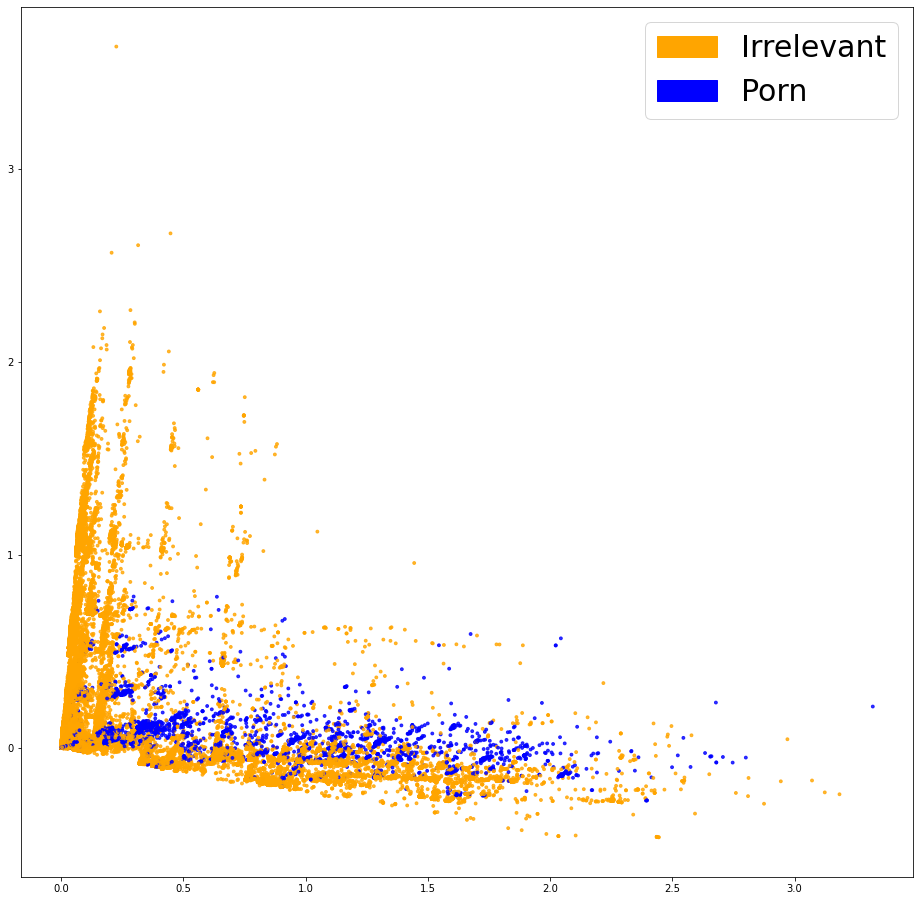

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="/content/drive/MyDrive/ML_Techno_2021/data/train.csv/PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Porn')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

Под меткой "Irrelevant" скрывается все, что не относитеся к порнографии

Обучим модель логистической регресссии и посмотрим на ее качество.
Все составляющие модели были ранее подобраны при помощи перебора по сетке. Данный этап здесь опущен, так как занимал достаточно большое время

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
print(classification_report(y_test, y_predicted_counts, digits=3))

              precision    recall  f1-score   support

       False      0.992     0.994     0.993     35306
        True      0.955     0.945     0.950      5029

    accuracy                          0.988     40335
   macro avg      0.974     0.969     0.971     40335
weighted avg      0.987     0.988     0.988     40335



AUC-ROC metric: 0.969


Text(0.5, 1.0, 'ROC curve')

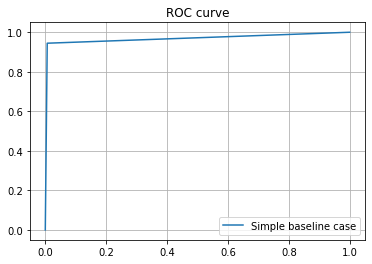

In [ ]:
print(f"AUC-ROC metric: {round(roc_auc_score(y_test, y_predicted_counts), 3)}")
fpr, tpr, _ = roc_curve(y_test, y_predicted_counts)

plt.plot(fpr, tpr, label="Simple baseline case")
plt.legend()
plt.grid()
plt.title('ROC curve')

Качество заметно улучшилось по сравнению с обычной моделью. Однако все равно есть маневры для улучшения.
Посмотрим на то, где наша модель ошибается при помощи confusion matrix

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

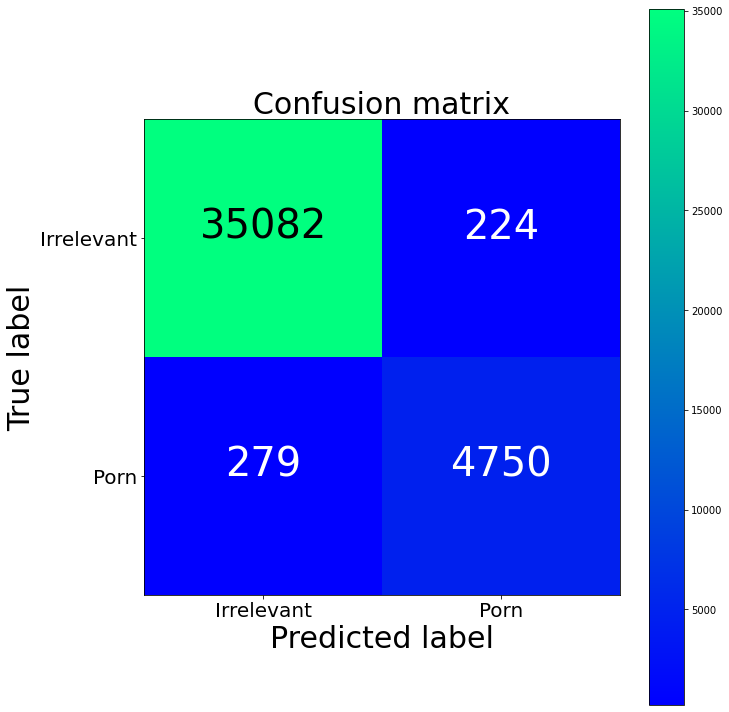

[[35082   224]
 [  279  4750]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Porn'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Наша модель склонна к ошибке первого рода - детектирует "порно" как "не порно". Что с точки зрения пользователя достаточно критично. Посмотрим глубже, как наша модель воспринимает слова и в какую категорию их относит

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]

        classes[class_index] = { 'tops':tops, 'bottom':bottom }

    return classes

In [ ]:
importance = get_most_important_features(count_vectorizer, clf, 20)

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Porn', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

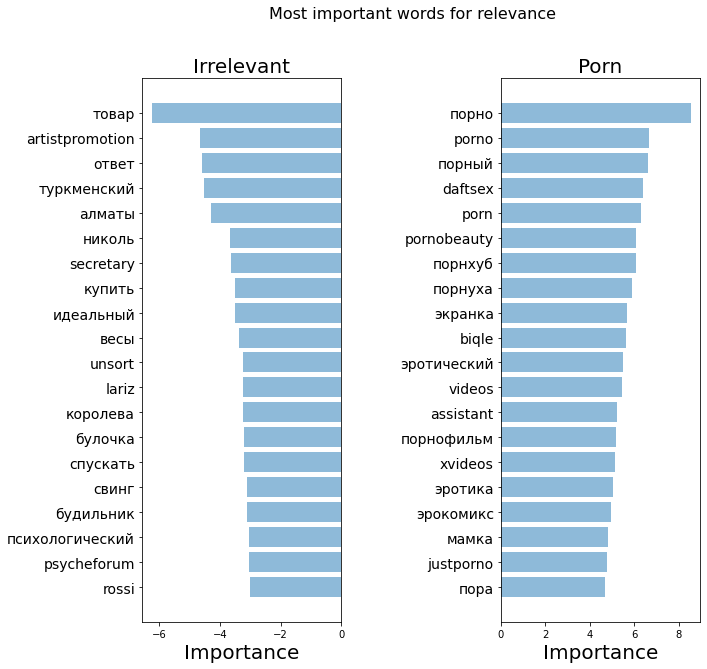

In [ ]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

В целом, модель справляется достаточно хорошо.
Однако есть и промахи - "свинг" явно относится к категории "порно", а "пора" наоборот.  
Требуется улучшение

## Part 2.2. TFIDF
Попробуем добавить важность конкретного слова в конкретном описании при помощи tfidf

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

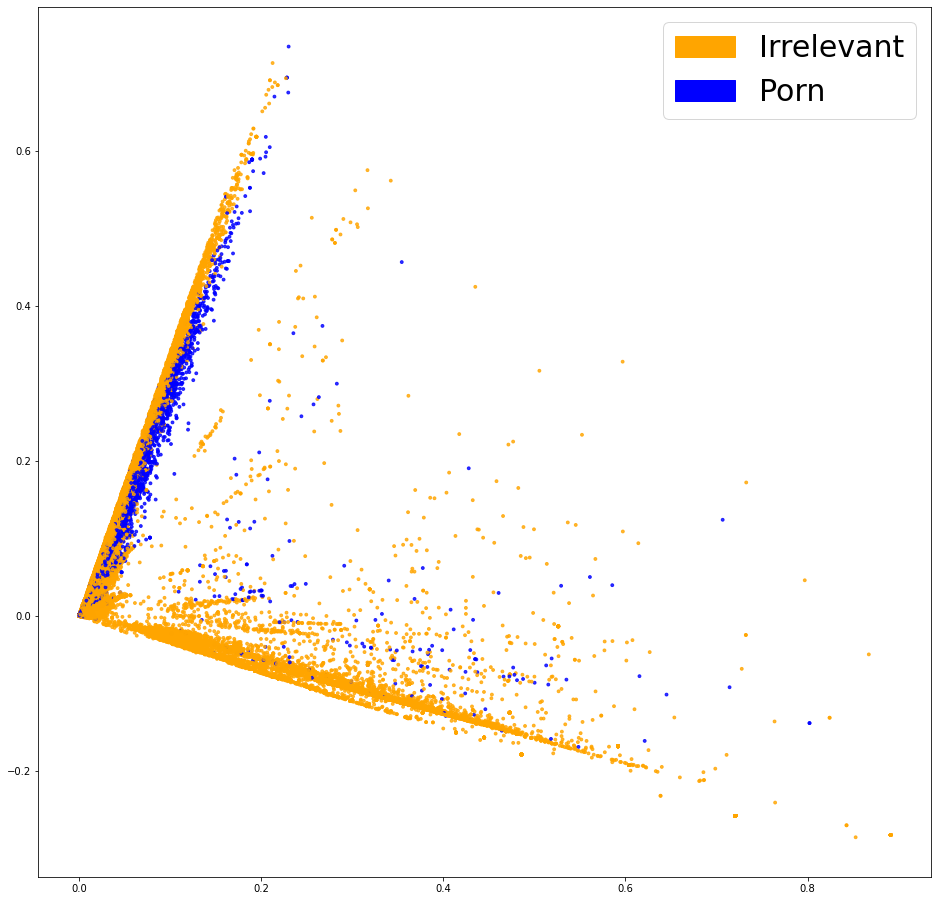

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

Как видно, разделимость классов стала много лучше, однако все равно один класс как бы "лежит" внутри другого и для моделей "классической" линейной классификации трудно будет их различить

In [ ]:
param_grid = {"C": [1, 5, 10, 30, 40, 50], "class_weight" : ["balanced"], 
             "solver": ["newton-cg"], "multi_class" : ["multinomial"]}

In [ ]:
estimator = LogisticRegression(n_jobs=-1, random_state=40)
clf_tfidf = GridSearchCV(estimator, param_grid, cv = 5)
clf_tfidf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=40),
             param_grid={'C': [1, 5, 10, 30, 40, 50],
                         'class_weight': ['balanced'],
                         'multi_class': ['multinomial'],
                         'solver': ['newton-cg']})

In [ ]:
clf_tfidf.best_estimator_

LogisticRegression(C=10, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

Обучим два классификатора - логистическую регрессию и SGD, сравним их качество.
Для логистической регрессии параметры были получены ранее при помощи перебора по сетке.

In [ ]:
clf_tfidf = LogisticRegression(C=10.0, class_weight='balanced', solver='newton-cg', 
                               multi_class='multinomial', n_jobs=-1, random_state=40)

clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test, y_predicted_tfidf, digits=4))

              precision    recall  f1-score   support

       False     0.9929    0.9936    0.9932     35306
        True     0.9550    0.9499    0.9524      5029

    accuracy                         0.9882     40335
   macro avg     0.9739    0.9718    0.9728     40335
weighted avg     0.9881    0.9882    0.9882     40335



TFIDF позволил выиграть в качестве модели, но не слишком много

In [ ]:
param_grid = {"alpha": [0.0001, 0.001, 0.01], "class_weight" : ["balanced", None], "eta0" : [0.1, 0.2, 0.5]}

In [ ]:
SGDClassifier?

In [ ]:
estimator = SGDClassifier(n_jobs=-1, random_state=40, learning_rate = 'adaptive', loss = 'perceptron', early_stopping = True, 
                          validation_fraction = 0.2, eta0=0.1)
clf_tfidf = GridSearchCV(estimator, param_grid, cv = 5)
clf_tfidf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(early_stopping=True, eta0=0.1,
                                     learning_rate='adaptive',
                                     loss='perceptron', n_jobs=-1,
                                     random_state=40, validation_fraction=0.2),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'class_weight': ['balanced', None],
                         'eta0': [0.1, 0.2, 0.5]})

In [ ]:
clf_tfidf.best_estimator_

SGDClassifier(alpha=0.001, early_stopping=True, eta0=0.1,
              learning_rate='adaptive', loss='perceptron', n_jobs=-1,
              random_state=40, validation_fraction=0.2)

In [ ]:
clf_tfidf = SGDClassifier(random_state=40,
                          learning_rate = 'adaptive', eta0 = 0.1,
                          loss = 'perceptron', alpha=0.0001,
                          early_stopping = True, validation_fraction = 0.2,
                          n_jobs = -1)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf_sgd = clf_tfidf.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test, y_predicted_tfidf_sgd, digits=4))

              precision    recall  f1-score   support

       False     0.9891    0.9931    0.9911     35306
        True     0.9499    0.9228    0.9362      5029

    accuracy                         0.9843     40335
   macro avg     0.9695    0.9580    0.9636     40335
weighted avg     0.9842    0.9843    0.9842     40335



SGD классификатор только ухудшил качество модели

AUC-ROC metric: 0.972


Text(0.5, 1.0, 'ROC curve')

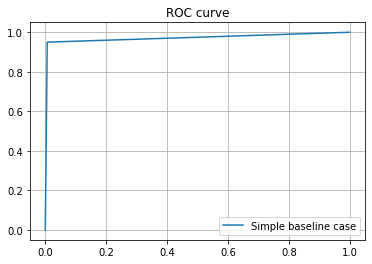

In [ ]:
print(f"AUC-ROC metric: {round(roc_auc_score(y_test, y_predicted_tfidf), 3)}")
fpr, tpr, _ = roc_curve(y_test, y_predicted_tfidf)

plt.plot(fpr, tpr, label="Simple baseline case")
plt.legend()
plt.grid()
plt.title('ROC curve')

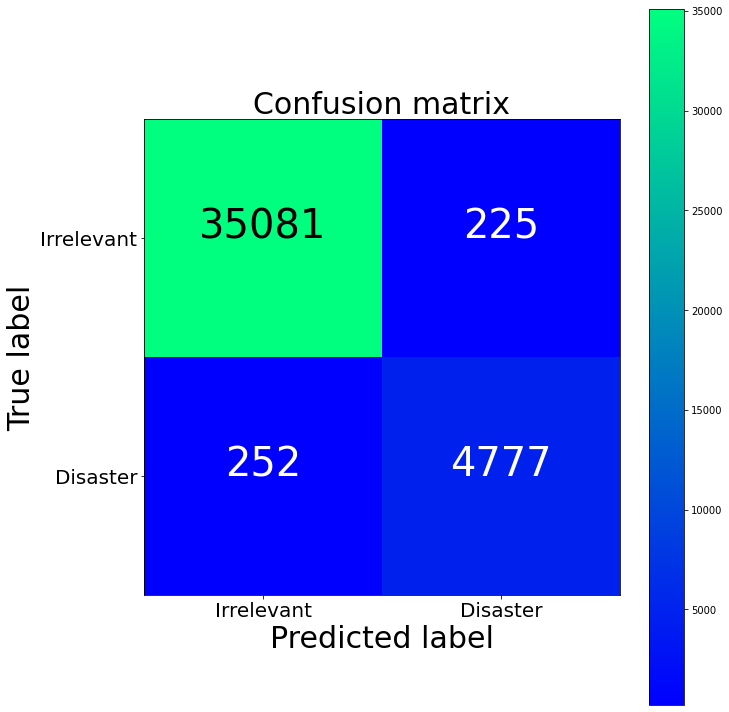

TFIDF confusion matrix
[[35081   225]
 [  252  4777]]
BoW confusion matrix
[[35082   224]
 [  279  4750]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Модель стала меньше ошибаться в ошибках I рода.
Посмотрим глубже, как наша модель воспринимает слова и в какую категорию их относит

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 20)

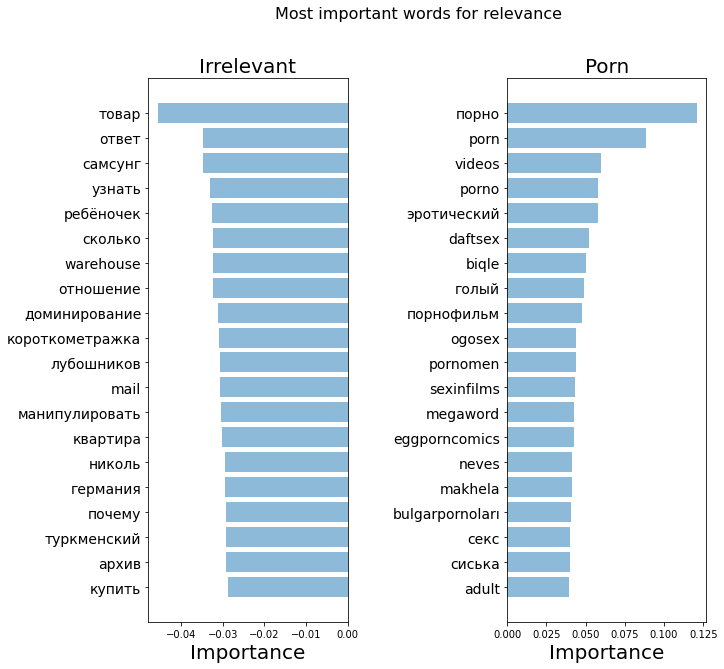

In [ ]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Все равно имеются промахи в словах

In [ ]:
X_test_main = test_df["title"].tolist()
X_test_tfidf = tfidf_vectorizer.transform(X_test_main)

test_df["target"] =  clf_tfidf.predict(X_test_tfidf)

In [ ]:
# Create file and read in stdout

test_df[["id", "target"]].to_csv("ml_tfidf.csv", index=False)
!cat ml_tfidf.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False
cat: ошибка записи: Обрыв канала


# Conclusion:
На Kaggle данная модель показала 0.95466 по f1-метке.